In [1]:
# -*- coding: utf-8 -*-

### Imports ###
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras.datasets import mnist

matplotlib.rcParams["figure.dpi"] = 300  # highres display
from IPython.display import clear_output
from time import sleep
from google.colab import files


In [2]:
### Helper Functions ###
def HammingDistance(x, y):
    "gives Hamming distance b/w #x and #y"
    count = 0
    if len(x) == len(y):
        for _ in range(len(x)):
            if x[_] != y[_]:
                count += 1
    else:
        raise ValueError("Incorrect dimensions of input vectors")
    return count / len(x)


def SyncUpdate(W, x):
    "returns the synchronously updated neuron values #x using #W"
    ### choose preferred #activation function {step, sign, sigmoid}
    return np.sign(np.dot(W, x))


def AsyncUpdate(W, x, updates=10):
    "returns the asynchronously updated neuron values #x using #W"
    for _ in np.random.randint(low=0, high=len(x), size=updates):
        x[_] = np.sign(np.dot(W[_, :], x))
    return x


def ProbUpdate(W, x, beta=10, updates=10):
    "returns the Metropolis updated neuron values #x using #W. #beta is the temperature parameter"
    for _ in np.random.randint(0, len(x), size=updates):
        h_ = float(np.dot(W[_, :], x)/len(x))
        x[_] = np.random.choice([+1, -1], p=[Sigmoid(2*beta*h_), Sigmoid(-2*beta*h_)])
    return x


def Energy(W, x):
    "return the energy of a particular configuration #x of neuron values"
    return -0.5 * (1 / len(x)) * float(np.dot(x.transpose(), np.dot(W, x)))


def Sigmoid(x):
    "return the sigmoid of x#"
    return 1 / (1 + np.exp(-x))
  
def Recast(number):
    "recasts a standard mnist image into bipolar image "
    number = (number< 100)*1
    number[number== 0] = -1
    return number

In [ ]:
### Main Driver Code ### ~
def Run(steps ,x0 ,xf ,W ,update_rule = 'AsyncUpdate', skip_steps= 10):
      """ function to update configutation ;
          steps: no. of updates
          x0: input a initial config, default: a random initial config will be chosen
          xf: input the list of stored configutations as np arrays; eg. xf= [config_1, config_2,...]
          W: input the Weight matrix 
          update_rule: specify the update rule from {'SyncUpdate','AsyncUpdate','ProbUpdate'}, default: 'Asyncupdate'
          skip_steps: no. of steps skipped while visualization 

          Returns; none """
      
      N = len(x0)
      n = int(np.sqrt(N))
      E = [] ## list to store energy
      h = [] ## list to store hamming distance
      legend = []
      for _ in range(1,len(xf)): legend.append("config_"+str(_))

      for _ in range(steps):
        p = []
        if update_rule== 'SyncUpdate' : x0 = SyncUpdate(W, x0)
        elif update_rule== 'AsyncUpdate' : x0 = AsyncUpdate(W,x0, updates= 10)
        elif update_rule== 'ProbUpdate' : x0 = ProbUpdate(W,x0,updates=100)
        E.append(Energy(W,x0))
        for x in xf: p.append(HammingDistance(x,x0))
        h.append(p)

        ## visualization sub-routine ~ 
        if (_%skip_steps == 0):
            clear_output(wait= True)
            plt.figure(figsize= (24,8))
            plt.subplot(131)
            plt.title("Current Config: ")
            sns.heatmap(x0.reshape(n,n),xticklabels= False, yticklabels= False, cbar= False)
            plt.subplot(132)
            plt.title('Energy')
            plt.plot(np.linspace(0,len(E),len(E)),E)
            plt.xlabel('Iterations ->')
            plt.subplot(133)
            plt.title('Hamming distance')
            plt.plot(np.linspace(0,len(E),len(E)),h )
            plt.legend(legend)
            plt.xlabel('Iterations ->')
            
            plt.savefig("slide_"+str(int(_/skip_steps))+".png")
            #files.download("slide_"+str(int(_/skip_steps))+".png")
            plt.show()
            sleep(0.01)

      return h


In [ ]:
### Import MNIST data ~
(train_x, train_y), (test_x , test_y) = mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
### Initializations ###
def InitializeNetwork_mnist(nrange=10,index= 70,weight_randomization= True):
    """ function to initialize network ;
        n: dimensions of the neuronal lattice, no. of neurons = n*n
        weight_randomization: If True, randomly alters the values in the weight matrix
        N.B. ~ specify the stored configurations to the list xf
       
       Returns~ x0: a random initial config, xf: list of saved configs as 1d vector, W: weight matrix  """
    
    ## number of neurons "N"~
    n = 28 ## as mnist images are 28*28 grids
    N = n*n 

    ###  MNIST data to be train the network "stored_configs" ~
    stored_configs = []
    for number in range(nrange):
      _ = index
      while train_y[_]!= number :
        _+= 1
      else: stored_configs.append(train_x[_])
    for number in range(len(stored_configs)):
      stored_configs[number] = Recast(stored_configs[number])
    
    ## vectorize stored configurations as 1d vector ~
    xf = []
    for config in stored_configs: xf.append(np.reshape(config,(N,1)))

    ## MNIST data as initial config "initial_configs" ~
    initial_configs = []
    for number in range(50):
       initial_configs.append(test_x[number])
    for number in range(len(initial_configs)):
      initial_configs[number] = Recast(initial_configs[number])
    
    ## vectorize initial configurations as 1d vector ~
    x0 = []
    for config in initial_configs: x0.append(np.reshape(config,(N,1)))

        
    ## plot stored configurations "stored_configs" ~
    plt.figure(figsize=(8,10))
    for _ in range(len(stored_configs)):
      plt.subplot(3,4 , _+1)
      plt.title("Config "+str(_)+": ")
      sns.heatmap(stored_configs[_],xticklabels= False, yticklabels= False, cbar= False)
    


    ## initialize weight matrix "W" ~
    W = np.zeros((N,N))
    for x in xf: W += np.outer(x,x) ## stored patterns 
    for _ in range(N): W[_,_] = 0 
    if weight_randomization == True: 
        rnd = np.random.randint(low=0, high=N, size=(int(N/10),2))
        for _ in range(len(rnd)): W[rnd[_]] *= -1

    ## plot the weight matrix "W" ~
    fig = plt.figure(figsize=(8,6))
    plt.title(" Weight Matrix :")
    sns.heatmap(W,xticklabels= False, yticklabels= False) ## plot weight matrix
    
    return x0, xf, W


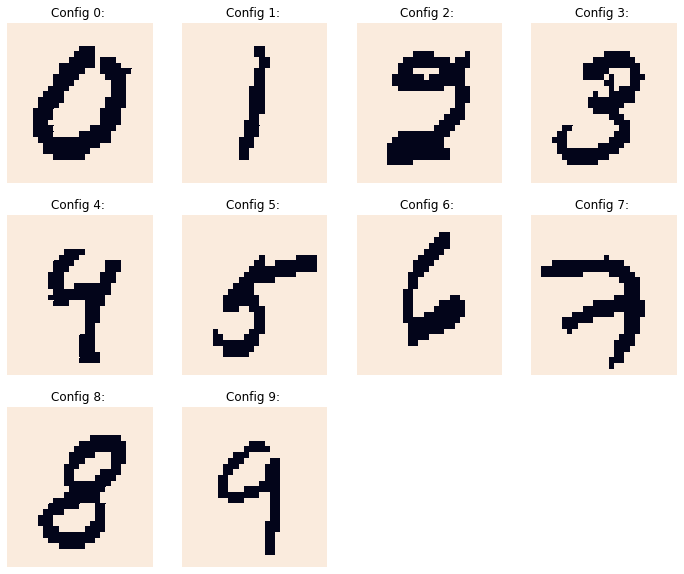

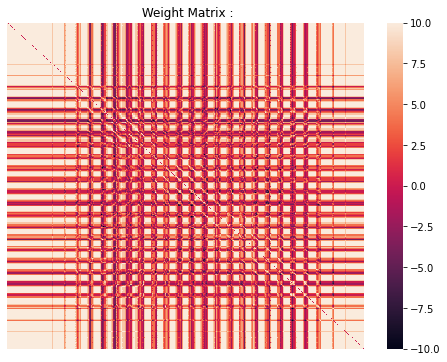

In [ ]:
x0, xf, W = InitializeNetwork_mnist( nrange= 10,index=5000 ,weight_randomization= False)

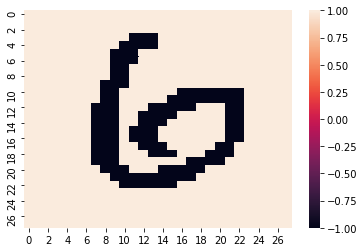

In [ ]:
sns.heatmap(x0[11].reshape((28,28)))

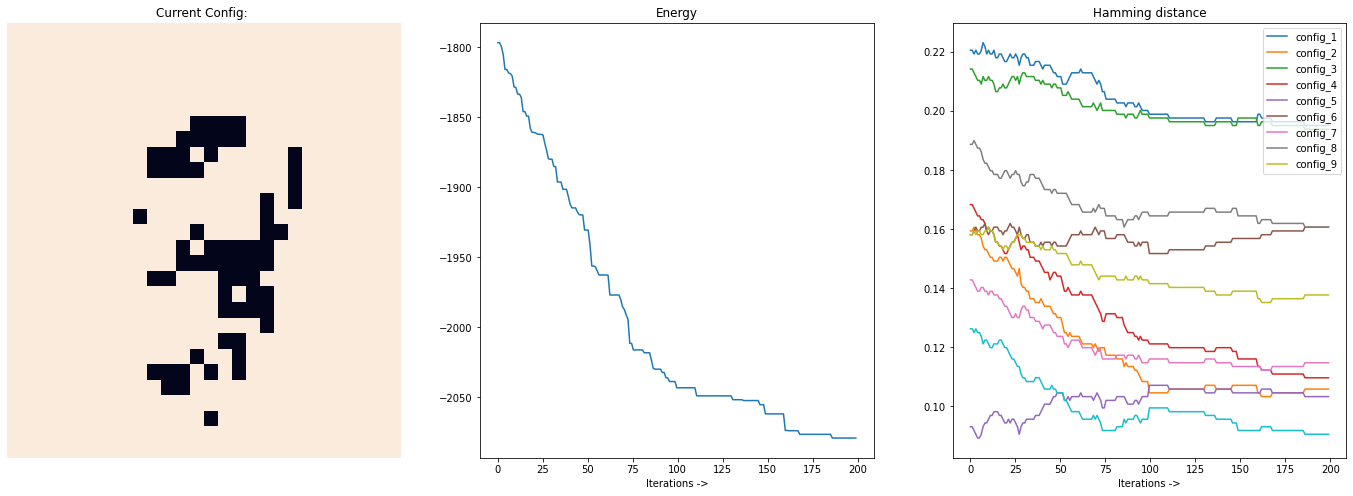

In [ ]:
h =Run(
    200,
    x0[12],
    xf,
    W,
    update_rule= 'AsyncUpdate',
    skip_steps=2,
)

In [ ]:
len(h[17])

10